# Cognition & Computation - Lab 3

In [1]:
def _get_files_from_repo(files, repo):
  repository_url = f"https://raw.githubusercontent.com/flavio2018/{repo}/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
files = ["DBN.py", "RBM.py"]
_get_files_from_repo(files, "Deep-Belief-Network-pytorch")

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as functional
import torchvision as tv
import tqdm

from DBN import DBN

## MNIST dataset

In [4]:
%%capture
mnist_train = tv.datasets.MNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

mnist_test = tv.datasets.MNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [5]:
mnist_train.data = (mnist_train.data.type(torch.FloatTensor)/255)
mnist_test.data = (mnist_test.data.type(torch.FloatTensor)/255)

In [6]:
device = torch.device("cpu")

## Models training

### RBM

In [7]:
dbn_mnist = DBN(visible_units=28*28,
                hidden_units=[500],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.0002,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=False)
                # use_gpu=True)

In [8]:
num_epochs = 40
batch_size = 125

dbn_mnist.train_static(
    mnist_train.data,
    mnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |mean_cost |std_cost  |mean_grad |std_grad  |
|01    |3.9082    |2.2547    |1286.2472 |3370.3706   |
|02    |1.9860    |0.2127    |1340.9116 |99.8327   |
|03    |1.6862    |0.1317    |1418.1321 |88.5877   |
|04    |1.5713    |0.1088    |1443.6851 |88.2617   |
|05    |1.4962    |0.1008    |1450.9946 |87.6031   |
|06    |1.9114    |0.2880    |1296.7885 |181.2151   |
|07    |1.6780    |0.1384    |1206.4896 |96.3153   |
|08    |1.6121    |0.1294    |1198.9965 |92.9933   |
|09    |1.5704    |0.1317    |1195.1605 |93.6852   |
|10    |1.5209    |0.1138    |1191.9240 |82.5917   |
|11    |1.5057    |0.1121    |1198.0924 |84.9181   |
|12    |1.4856    |0.1187    |1196.4677 |89.8396   |
|13    |1.4641    |0.1088    |1195.1652 |85.5010   |
|14    |1.4494    |0.1092    |1199.8986 |83.5561   |
|15    |1.4329    |0.1087    |1195.2886 |87.1571   |
|16    |1.4297    |0.1137    |1205.3746 |93.6502   |
|17    |1.4122    |0.1094    |1195.1057 |86.9792   |
|

In [9]:
def _move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [10]:
_move_parameters_to_cpu(dbn_mnist)

### Readout layer

In [11]:
def _get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_mnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [12]:
def _train(network, input, epochs=1000, device=device):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  targets_on_device = mnist_train.targets.to(device)

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input)
    loss = loss_fn(predictions, targets_on_device)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

In [13]:
class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [14]:
hidden_repr_layer_1 = _get_kth_layer_repr(mnist_train.data, 0)

In [15]:
rbm_layer_size = dbn_mnist.rbm_layers[0].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size)
_train(perceptron_first_hidden, hidden_repr_layer_1, epochs=1500)

epoch 0/1500, loss = 2.307380


### Feedforward model

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, 10)

  def forward(self, input):
    input = input.view((input.shape[0], -1))
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output

In [ ]:
ffnn = Feedforward(500)

235 sec

In [ ]:
_train(ffnn, mnist_train.data, epochs=120)

epoch 0/120, loss = 2.313950
epoch 10/120, loss = 2.171087
epoch 20/120, loss = 2.022790
epoch 30/120, loss = 1.855110
epoch 40/120, loss = 1.671579
epoch 50/120, loss = 1.486950
epoch 60/120, loss = 1.317399
epoch 70/120, loss = 1.172361
epoch 80/120, loss = 1.053361
epoch 90/120, loss = 0.957340
epoch 100/120, loss = 0.879893
epoch 110/120, loss = 0.816902


## Adversarial attacks

### Fast gradient sign method

Reference: https://jaketae.github.io/study/fgsm/

In general, with adversarial attacks we need to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

The loss is usually a function of the input, the model's parameters and the outputs: $J(w, x, y)$.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure: 
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

### Adversarial samples

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, perceptron):
        super().__init__()
        self.readout = perceptron
        self.dbn_mnist = dbn_mnist

    def forward(self, image):
        x, __ = self.dbn_mnist.forward(image)
        x = self.readout.forward(x)
        return x

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_mnist, perceptron_first_hidden)

Let's see what an adversiarial sample looks like. Let't take one sample from the test set:

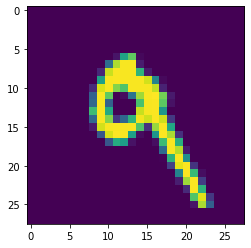

In [ ]:
test_image = mnist_test.data[7].reshape(1, 28, 28)
__ = plt.imshow(test_image.reshape(28,28))

Now let's classify this image using a model, and modify the image to attack the network. To change the model we attack, you can modify the value of the `model` variable in the cell below (choosing between `ffnn` and `dbn_with_readout`).

In [ ]:
attacked_model = ffnn

In [ ]:
test_image.requires_grad = True
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this sample is {prediction}.")

test_image_label = mnist_test.targets[:1]
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, 0.2, image_grad)

The prediction of the model for this sample is 9.


Let's look at the adversarial sample:

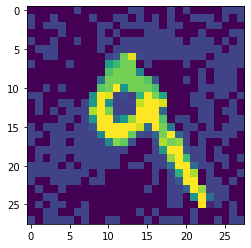

In [ ]:
perturbed_image_np = perturbed_image.detach().numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 4.


### Resisting to adversarial attacks

Let's now compare the ability to resist to adversarial attacks of our two models: the feedforward network and the RBM.

We will also test the ability of the RBM to reduce the impact of the attack by performing one or more reconstruction steps, from the hidden representation to the visible units, and back to the hidden representation.

In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm.tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(1, 28, 28)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data.detach().numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if verbose:
      print("\nEpsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon,
            correct, len(test_loader), final_acc))

    return final_acc

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.MNIST('data/', train=False, download=False, transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
    ])),
    batch_size=1, shuffle=True)

Let's see how good the FFNN does:

In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

100%|██████████| 10000/10000 [00:21<00:00, 465.06it/s]


Epsilon: 0.1	Test Accuracy = 5586 / 10000 = 0.5586



Let's now compare compare the hidden representations of the RBM:

In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

100%|██████████| 10000/10000 [00:15<00:00, 647.59it/s]


Epsilon: 0.1	Test Accuracy = 6244 / 10000 = 0.6244



Now let's test the reconstruction power of the generative model:

  0%|          | 0/10000 [00:00<?, ?it/s]


Here's the original sample:



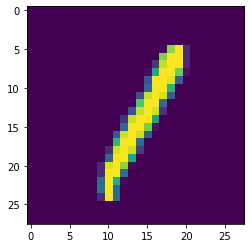


Here's a perturbed sample:



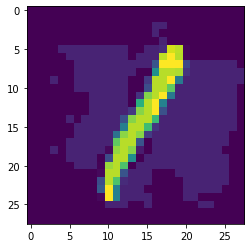


Here's what a 1-steps reconstructed sample looks like:



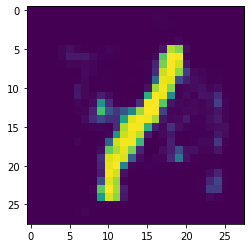

100%|██████████| 10000/10000 [00:22<00:00, 443.78it/s]


Epsilon: 0.1	Test Accuracy = 6917 / 10000 = 0.6917



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

### Effect of the parameter $\epsilon$

Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [ ]:
epsilon_values = [0, .05, .1, .15, .2, .25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_rbm_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_rbm_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)
accuracies_rbm_2 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)

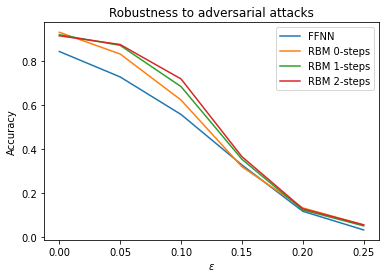

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), sharey=True)

__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_rbm_0)
__ = ax.plot(epsilon_values, accuracies_rbm_1)
__ = ax.plot(epsilon_values, accuracies_rbm_2)
__ = ax.set_xlabel("$\epsilon$")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks")
__ = ax.legend(["FFNN", "RBM 0-steps", "RBM 1-steps","RBM 2-steps"])

## Contacts

- 📧 flavio.petruzzellis@phd.unipd.it
- 💬 [Moodle forum](https://elearning.unipd.it/math/mod/forum/view.php?id=36439)